<a href="https://colab.research.google.com/github/mahmoud25112/Customer_Sentiment_analysis_BERT/blob/main/code/Sentiment_analysis_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve
)
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/KaggleDatasets/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1', header = None)

df.columns = ['target', 'id', 'date', 'query', 'user', 'text']



df = df[['target', 'text']]
df.head()


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df['text_length'] = df['text'].apply(len)
df.head()

,target,text,text_length
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


In [ ]:
df.groupby('target')['text_length'].mean()

,text_length
target,
0,74.301790
4,73.878433


it has no effect we will remove it


In [ ]:
df = df[['target', 'text']]

In [ ]:
df['target'].value_counts()

,count
target,
0,800000
4,800000


In [ ]:
df['target'] = df['target'].replace(4, 1)
df['target'].value_counts()

<ipython-input-10-7c782787fec3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = df['target'].replace(4, 1)


,count
target,
0,800000
1,800000


1 represnts positive sentiment and 0 represents negative sentiment

In [ ]:
df.isna().sum()

,0
target,0
text,0


In [ ]:
# Preprocessing function
def preProcess(text):
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Replace URLs and mentions
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text)
    text = re.sub(r'@\w+', '[USER]', text)

    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize, remove stopwords, and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)

df['clean_text'] = df['text'].apply(preProcess)




In [ ]:
df.head()

,target,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",thats bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see


In [ ]:
df.rename(columns={'target': 'sentiment'}, inplace=True)

# TF.IDF

In [ ]:
# Split the data
X = df['clean_text']
y = df['sentiment']  # 0 = negative, 1 = positive
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply TF-IDF
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
X_val_vec = vectorizer.transform(X_val)

We're starting with max fetaures as 5000 to try differnt models first then we'll start hyperparmaeter tuning

In [ ]:

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_vec, y_train)
y_pred_log_reg = log_reg.predict(X_val_vec)
print("Logistic Regression Report:\n", classification_report(y_val, y_pred_log_reg))


xgb_clf = XGBClassifier(tree_method='gpu_hist', gpu_id=0, random_state=42)
xgb_clf.fit(X_train_vec, y_train)  # Training on GPU
y_pred_xgb = xgb_clf.predict(X_val_vec)

# Print classification report for XGBoost
print("XGBoost Report:\n", classification_report(y_val, y_pred_xgb))

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.79      0.75      0.77    128598
           1       0.76      0.80      0.78    127402

    accuracy                           0.77    256000
   macro avg       0.78      0.77      0.77    256000
weighted avg       0.78      0.77      0.77    256000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:20:34] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:20:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:20:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [

XGBoost Report:
               precision    recall  f1-score   support

           0       0.89      0.07      0.13    128598
           1       0.51      0.99      0.68    127402

    accuracy                           0.53    256000
   macro avg       0.70      0.53      0.40    256000
weighted avg       0.70      0.53      0.40    256000



In [ ]:

# Define a dictionary to store model results
model_results = []

# Logistic Regression Pipeline
log_reg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Fixed TF-IDF parameters
    ('log_reg', LogisticRegression(random_state=42, max_iter=200, solver='lbfgs'))
])
log_reg_pipeline.fit(X_train, y_train)
y_pred_log_reg_val = log_reg_pipeline.predict(X_val)

# Save Logistic Regression results
model_results.append({
    'Model': 'Logistic Regression',
    'Validation Accuracy': accuracy_score(y_val, y_pred_log_reg_val)
})

print("Logistic Regression Validation Report:")
print(classification_report(y_val, y_pred_log_reg_val))

# XGBoost Model
xgb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('xgb', XGBClassifier(
        tree_method='gpu_hist',
        gpu_id=0,
        random_state=42,
        scale_pos_weight=1.2,  # Focus on the negative class
        max_depth=4,           # Shallower trees for better generalization
        learning_rate=0.1,     # Reduce step size for smoother updates
        min_child_weight=2,    # Avoid splitting on noise
        gamma=0.2,             # Regularize tree splits
        reg_lambda=1.0,        # L2 regularization
        reg_alpha=0.5          # L1 regularization
    ))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb_val = xgb_pipeline.predict(X_val)

# Save XGBoost results
model_results.append({
    'Model': 'XGBoost',
    'Validation Accuracy': accuracy_score(y_val, y_pred_xgb_val)
})

print("XGBoost Validation Report:")
print(classification_report(y_val, y_pred_xgb_val))

# Create a DataFrame for comparison
results_df = pd.DataFrame(model_results)
print("Model Comparison:")
print(results_df)

# Optional: Save results to CSV for future reference
results_df.to_csv('model_comparison_results.csv', index=False)


Logistic Regression Validation Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    128598
           1       0.76      0.80      0.78    127402

    accuracy                           0.77    256000
   macro avg       0.78      0.77      0.77    256000
weighted avg       0.78      0.77      0.77    256000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:21:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:21:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost Validation Report:
              precision    recall  f1-score   support

           0       0.89      0.07      0.13    128598
           1       0.51      0.99      0.68    127402

    accuracy                           0.53    256000
   macro avg       0.70      0.53      0.40    256000
weighted avg       0.70      0.53      0.40    256000

Model Comparison:
                 Model  Validation Accuracy
0  Logistic Regression             0.774660
1              XGBoost             0.528457


## Tryin Different Vectors count



In [ ]:

# Function to evaluate models with specified vector size
def evaluate_models_with_vector_size(vector_size, X_train, y_train, X_test, y_test):
    print(f"\nEvaluating models with TF-IDF max_features={vector_size}...\n")

    # Update TF-IDF vectorizer
    vectorizer = TfidfVectorizer(max_features=vector_size)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Store results
    results = []

    # Logistic Regression
    log_reg = LogisticRegression(random_state=42, max_iter=200, solver='lbfgs')
    log_reg.fit(X_train_vec, y_train)
    y_pred_log_reg = log_reg.predict(X_test_vec)
    results.append({
        'Model': 'Logistic Regression',
        'Vector Size': vector_size,
        'Test Accuracy': accuracy_score(y_test, y_pred_log_reg)
    })
    print(f"Logistic Regression Report (Vector Size={vector_size}):\n")
    print(classification_report(y_test, y_pred_log_reg))

    # XGBoost
    xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0, random_state=42)
    xgb.fit(X_train_vec, y_train)
    y_pred_xgb = xgb.predict(X_test_vec)
    results.append({
        'Model': 'XGBoost',
        'Vector Size': vector_size,
        'Test Accuracy': accuracy_score(y_test, y_pred_xgb)
    })
    print(f"XGBoost Report (Vector Size={vector_size}):\n")
    print(classification_report(y_test, y_pred_xgb))

    return results

# Evaluate with vector sizes 3000 and 7000
results_3000 = evaluate_models_with_vector_size(3000, X_train, y_train, X_test, y_test)
results_7000 = evaluate_models_with_vector_size(7000, X_train, y_train, X_test, y_test)

# Combine results and display
combined_results = pd.DataFrame(results_3000 + results_7000)
print("\nModel Comparison Across Vector Sizes:")
print(combined_results)

# Optional: Save results to CSV
combined_results.to_csv('vector_size_comparison_results.csv', index=False)



Evaluating models with TF-IDF max_features=3000...

Logistic Regression Report (Vector Size=3000):

              precision    recall  f1-score   support

           0       0.78      0.74      0.76    159494
           1       0.76      0.79      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:21:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:21:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost Report (Vector Size=3000):

              precision    recall  f1-score   support

           0       0.89      0.07      0.13    159494
           1       0.52      0.99      0.68    160506

    accuracy                           0.53    320000
   macro avg       0.70      0.53      0.40    320000
weighted avg       0.70      0.53      0.41    320000


Evaluating models with TF-IDF max_features=7000...

Logistic Regression Report (Vector Size=7000):

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           1       0.76      0.80      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:21:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:21:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost Report (Vector Size=7000):

              precision    recall  f1-score   support

           0       0.89      0.07      0.13    159494
           1       0.52      0.99      0.68    160506

    accuracy                           0.53    320000
   macro avg       0.70      0.53      0.40    320000
weighted avg       0.70      0.53      0.41    320000


Model Comparison Across Vector Sizes:
                 Model  Vector Size  Test Accuracy
0  Logistic Regression         3000       0.767809
1              XGBoost         3000       0.531913
2  Logistic Regression         7000       0.775216
3              XGBoost         7000       0.531966


## Testing All Models on the Test Dataset

In [ ]:

# Dictionary to store test results
test_results = []

# Logistic Regression on Test Set
y_pred_log_reg_test = log_reg_pipeline.predict(X_test)
test_results.append({
    'Model': 'Logistic Regression',
    'Test Accuracy': accuracy_score(y_test, y_pred_log_reg_test)
})
print("Logistic Regression Test Report:")
print(classification_report(y_test, y_pred_log_reg_test))

# XGBoost on Test Set
y_pred_xgb_test = xgb_pipeline.predict(X_test)
test_results.append({
    'Model': 'XGBoost',
    'Test Accuracy': accuracy_score(y_test, y_pred_xgb_test)
})
print("XGBoost Test Report:")
print(classification_report(y_test, y_pred_xgb_test))

# Create a DataFrame for test set comparison
test_results_df = pd.DataFrame(test_results)
print("\nTest Set Model Comparison:")
print(test_results_df)

# Optional: Save test results to CSV for future reference
test_results_df.to_csv('test_set_results.csv', index=False)


Logistic Regression Test Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77    159494
           1       0.76      0.79      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000

XGBoost Test Report:
              precision    recall  f1-score   support

           0       0.89      0.07      0.13    159494
           1       0.52      0.99      0.68    160506

    accuracy                           0.53    320000
   macro avg       0.70      0.53      0.40    320000
weighted avg       0.70      0.53      0.41    320000


Test Set Model Comparison:
                 Model  Test Accuracy
0  Logistic Regression       0.772741
1              XGBoost       0.531919


## AUC-ROC Curves to evaluate the models

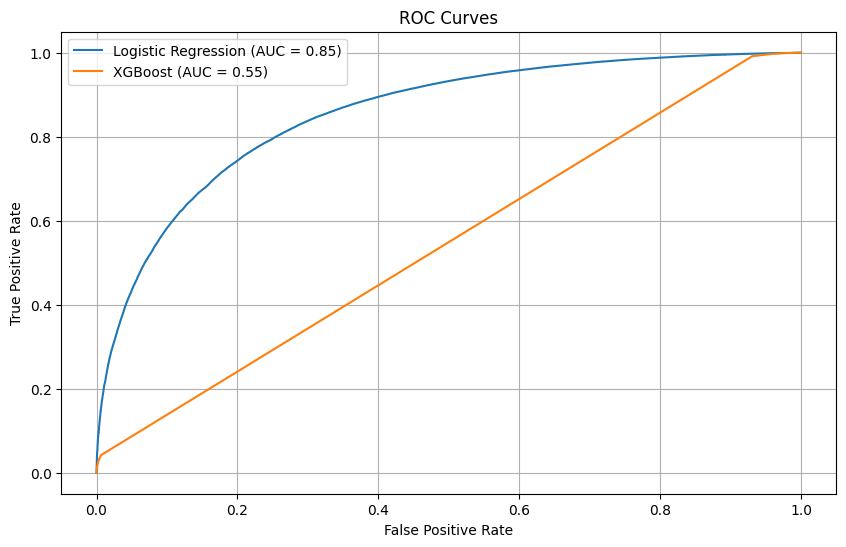

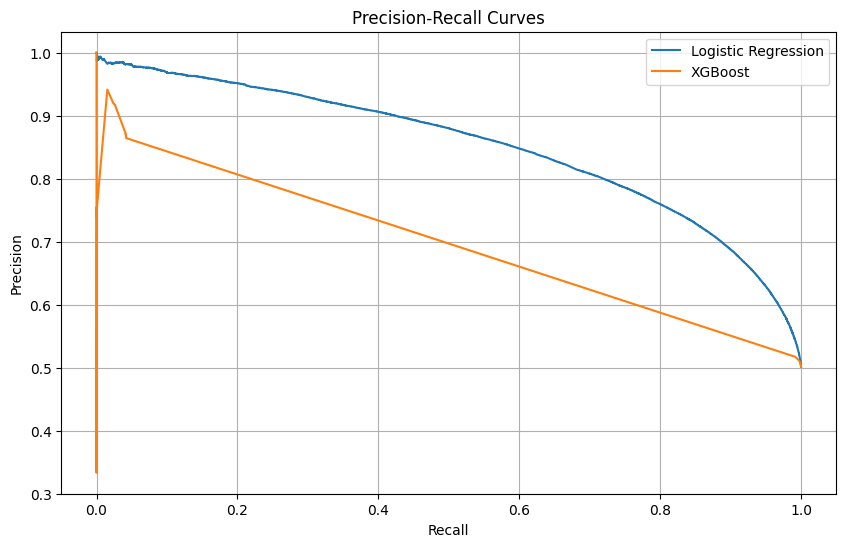

In [ ]:

# Logistic Regression ROC-AUC
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg_pipeline.predict_proba(X_test)[:, 1])
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# XGBoost ROC-AUC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pipeline.predict_proba(X_test)[:, 1])
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc_log_reg:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# Precision-Recall Curves
precision_log_reg, recall_log_reg, _ = precision_recall_curve(y_test, log_reg_pipeline.predict_proba(X_test)[:, 1])
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_pipeline.predict_proba(X_test)[:, 1])

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 6))
plt.plot(recall_log_reg, precision_log_reg, label=f'Logistic Regression')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost')
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()



## Decision Boundaries

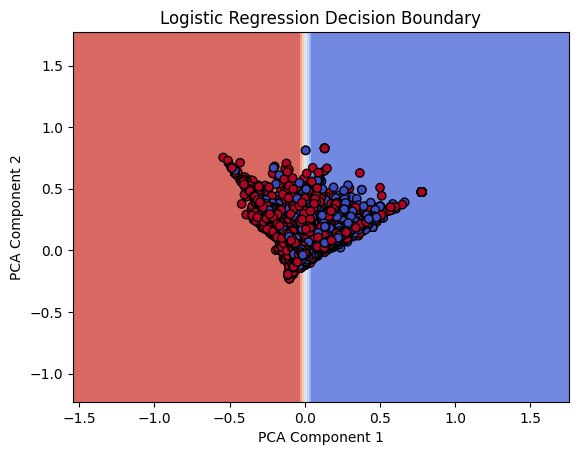

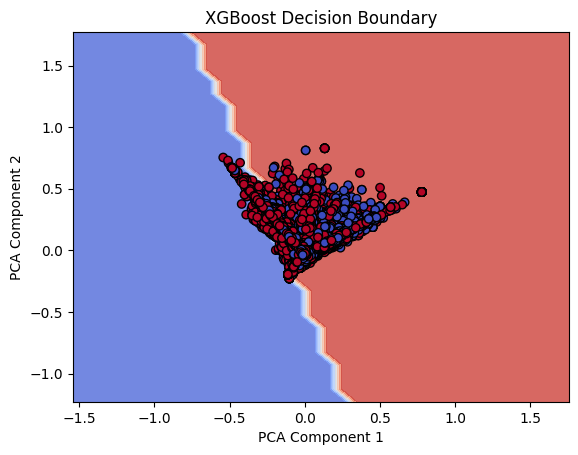

In [ ]:

# Reduce features to 2D using PCA
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_vec.toarray())  # Convert sparse matrix to dense
X_train_2d = pca.transform(X_train_vec.toarray())    # Apply PCA transformation to training data

# Define a function to plot decision boundaries
def plot_decision_boundary(model, pca, X_2d, X_full, y, title):
    x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
    y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Transform the 2D grid back to the original feature space
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_original = pca.inverse_transform(grid_points)

    # Predict on the original feature space
    Z = model.predict(grid_points_original)
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and scatter points
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Plot decision boundary for Logistic Regression
log_reg_best_model = log_reg_pipeline.named_steps['log_reg']  # Extract model from pipeline
plot_decision_boundary(log_reg_best_model, pca, X_test_2d, X_test_vec.toarray(), y_test.values, "Logistic Regression Decision Boundary")

# Plot decision boundary for XGBoost
xgb_best_model = xgb_pipeline.named_steps['xgb']  # Extract model from pipeline
plot_decision_boundary(xgb_best_model, pca, X_test_2d, X_test_vec.toarray(), y_test.values, "XGBoost Decision Boundary")


# Hyperparameter Tuning using GridSearchCV



In [ ]:


# Step 1: Optimize Features with TF-IDF and PCA
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))  # Using unigrams and bigrams
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Reduce Dimensions with Truncated SVD (PCA for sparse data)
svd = TruncatedSVD(n_components=300, random_state=42)  # Reduce to 300 dimensions
X_train_reduced = svd.fit_transform(X_train_vec)
X_test_reduced = svd.transform(X_test_vec)
print(f"Explained Variance: {sum(svd.explained_variance_ratio_):.2f}")  # Verify retained variance

# Step 2: Tune XGBoost with RandomizedSearchCV
param_dist = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [100, 200, 400],
    'min_child_weight': [1, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [1, 1.2],  # Adjust based on class difficulty
}

xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0, random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)
random_search.fit(X_train_reduced, y_train)

# Get the best model
best_xgb = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Step 3: Evaluate XGBoost on Test Set
y_pred_proba = best_xgb.predict_proba(X_test_reduced)[:, 1]  # Get probabilities
y_pred = best_xgb.predict(X_test_reduced)

# ROC-AUC Score for XGBoost
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"XGBoost ROC-AUC Score: {auc_score:.2f}")

# Classification Report for XGBoost
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred))

# Step 4: Adjust Decision Threshold for XGBoost
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Find optimal threshold for best F1-score
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold for XGBoost:", optimal_threshold)

# Apply the adjusted threshold
y_pred_adjusted = (y_pred_proba > optimal_threshold).astype(int)
print("XGBoost Adjusted Classification Report:\n", classification_report(y_test, y_pred_adjusted))


log_reg = LogisticRegression(random_state=42, max_iter=200)
log_reg.fit(X_train_reduced, y_train)
y_pred_lr = log_reg.predict(X_test_reduced)
y_pred_proba_lr = log_reg.predict_proba(X_test_reduced)[:, 1]

# Logistic Regression ROC-AUC
auc_score_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"Logistic Regression ROC-AUC Score: {auc_score_lr:.2f}")

# Logistic Regression Classification Report
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


Explained Variance: 0.44
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:39:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.8, 'scale_pos_weight': 1.2, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.3, 'colsample_bytree': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:39:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost ROC-AUC Score: 0.82
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.68      0.72    159494
           1       0.71      0.81      0.76    160506

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000

Optimal Threshold for XGBoost: 0.4232164
XGBoost Adjusted Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.59      0.68    159494
           1       0.68      0.86      0.76    160506

    accuracy                           0.73    320000
   macro avg       0.75      0.73      0.72    320000
weighted avg       0.75      0.73      0.72    320000

Logistic Regression ROC-AUC Score: 0.81
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.69      0.72    159494
           

In [ ]:
# XGBoost on Test Set
# Using the best XGBoost model from the earlier code
y_pred_xgb_test = best_xgb.predict(X_test_reduced)  # Use PCA-reduced data
y_pred_proba_xgb_test = best_xgb.predict_proba(X_test_reduced)[:, 1]  # Get probabilities

# Append XGBoost evaluation results to test_results
test_results.append({
    'Model': 'XGBoost',
    'Test Accuracy': accuracy_score(y_test, y_pred_xgb_test),
    'AUC': roc_auc_score(y_test, y_pred_proba_xgb_test)
})
print("XGBoost Test Report:")
print(classification_report(y_test, y_pred_xgb_test))

# Update the DataFrame with the new results
test_results_df = pd.DataFrame(test_results)  # Recreate the DataFrame with updated test_results
print("\nUpdated Test Set Model Comparison:")
print(test_results_df)

# Optional: Save updated results to CSV for future reference
test_results_df.to_csv('test_set_results.csv', index=False)




XGBoost Test Report:
              precision    recall  f1-score   support

           0       0.78      0.68      0.72    159494
           1       0.71      0.81      0.76    160506

    accuracy                           0.74    320000
   macro avg       0.74      0.74      0.74    320000
weighted avg       0.74      0.74      0.74    320000


Updated Test Set Model Comparison:
                 Model  Test Accuracy       AUC
0  Logistic Regression       0.772741       NaN
1              XGBoost       0.531919       NaN
2              XGBoost       0.740675  0.823932


AUC was recorded in the graph as 0.85 which means even after optimization logistic regression still performed better

In [ ]:
test_results_df

,Model,Test Accuracy,AUC
0,Logistic Regression,0.772741,NaN
1,XGBoost,0.531919,NaN
2,XGBoost,0.740675,0.823932


In [ ]:
# Assign the best model to champion_model
champion_model = log_reg_pipeline
champion_model_name = "Logistic Regression"  # Name the champion model for reference

print(f"Champion Model: {champion_model_name}")


Champion Model: Logistic Regression


## Confusion Matrix

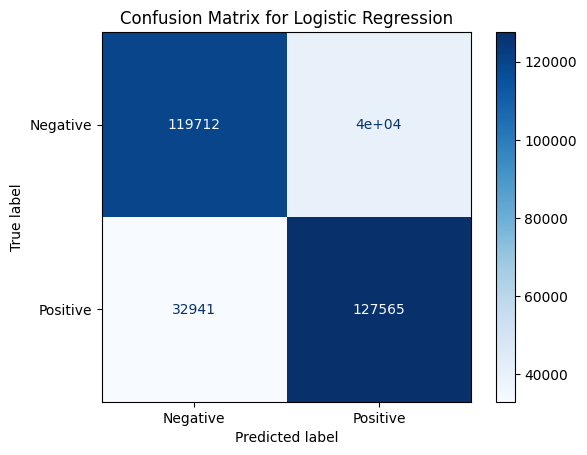

In [ ]:

# Predict using the champion model
y_pred_champion = champion_model.predict(X_test)  # Ensure X_test is preprocessed correctly in the pipeline

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_champion)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for {champion_model_name}")
plt.show()


## Feature Importance

In [ ]:
# Extract feature importance from Logistic Regression
# Absolute values of coefficients represent feature importance
feature_importance = abs(champion_model.named_steps['log_reg'].coef_[0])
feature_names = champion_model.named_steps['tfidf'].get_feature_names_out()

# Combine feature names and importance into a DataFrame
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)  # Sort by importance
print(importance_df.head(20))  # Display the top 20 features


            Feature  Importance
3676            sad    9.721195
3679          sadly    7.423567
4612  unfortunately    6.472684
608          bummed    6.356029
1200   disappointed    6.171282
664       cancelled    6.143950
2774           miss    6.133716
1894         gutted    6.100479
3611            rip    6.076101
1179           died    5.885878
3863           sick    5.643795
609          bummer    5.621095
3296           poor    5.608345
4638          upset    5.541098
2777        missing    5.383732
1144      depressed    5.367428
1145     depressing    5.305914
3662         ruined    5.239795
575          broken    5.117174
574           broke    5.104369


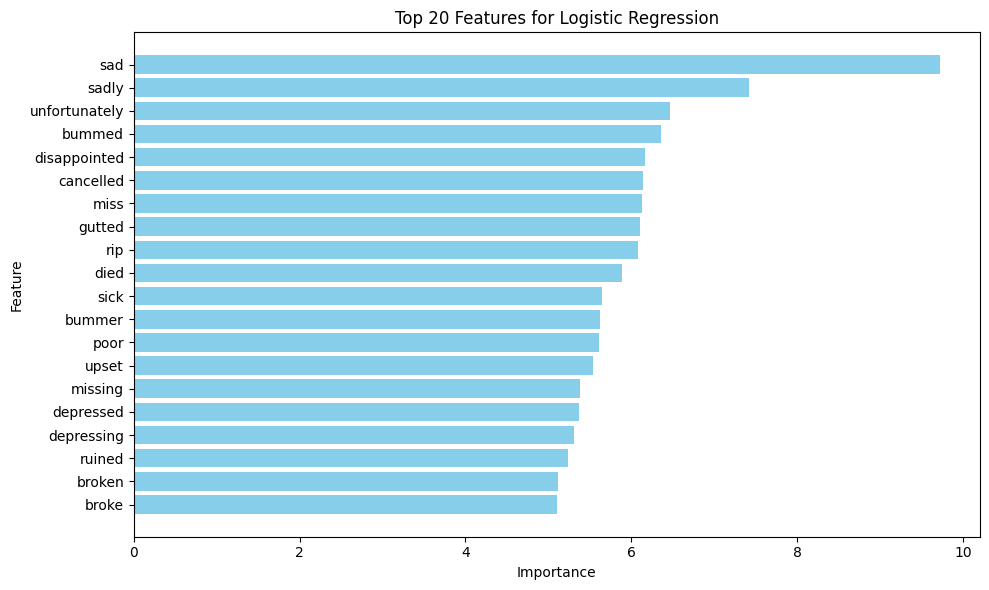

In [ ]:

# Plot the top 20 features
top_features = importance_df.head(20)  # Select top 20 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features on top
plt.title(f"Top 20 Features for {champion_model_name}")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


We can see the way the model suaulyy redicts is by looking for negative words , if negative words exist then is' a negative sentiment if not , then it's posisteve. It relies on negative emotion for both scenarios.

In [ ]:
!jupyter nbconvert /content/drive/MyDrive/Notebooks/Sentiment_analysis_log.ipynb --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/Notebooks/Sentiment_analysis_log.ipynb to html
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][29]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stdout',
 'output_type': 'stream',
 'text': 'Explained Variance: 0.44\n'
         'Fitting 3 folds for each of 20 candidat...'}
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 760510 bytes to /content/drive/MyDrive/Notebooks/Sentiment_analysis_log.html
